In [139]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support, log_loss
from sklearn.metrics.cluster import v_measure_score
from sklearn.cluster import DBSCAN

%matplotlib inline

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
df = pd.read_csv('/content/drive/MyDrive/datasets/data-mining-ui/project-3/dataset.csv')
df.head()

,Power(watts),Distance(metres),Heartrate(BPM),Speed(m/s),WindSpeed (m/s),Cadaence(revs/s),Elevation(meters),Hill slope(%),Temperature(C),Cluster
0,0.0,0.000,57.0,1.4305,1.6093,0.0,55.778,-2.85,25.556,C
1,0.0,0.000,57.0,1.6540,2.9505,0.0,55.778,-4.40,25.556,C
2,0.0,0.000,57.0,2.5034,3.1740,0.0,55.778,-5.85,25.556,C
3,0.0,16.093,61.0,2.5034,3.8445,0.0,55.778,-6.30,25.556,C
4,0.0,16.093,62.0,2.5481,3.2187,0.0,55.778,-5.62,25.556,C


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4435 entries, 0 to 4434
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Power(watts)       4433 non-null   float64
 1   Distance(metres)   4432 non-null   float64
 2   Heartrate(BPM)     4430 non-null   float64
 3   Speed(m/s)         4430 non-null   float64
 4   WindSpeed (m/s)    4417 non-null   float64
 5   Cadaence(revs/s)   4431 non-null   float64
 6   Elevation(meters)  4434 non-null   float64
 7   Hill slope(%)      4433 non-null   float64
 8   Temperature(C)     4433 non-null   float64
 9   Cluster            4435 non-null   object 
dtypes: float64(9), object(1)
memory usage: 346.6+ KB


In [143]:
df.describe()

,Power(watts),Distance(metres),Heartrate(BPM),Speed(m/s),WindSpeed (m/s),Cadaence(revs/s),Elevation(meters),Hill slope(%),Temperature(C)
count,4433.000000,4432.000000,4430.000000,4430.000000,4417.000000,4431.000000,4434.000000,4433.000000,4433.000000
mean,203.280929,13299.428148,134.679233,6.908460,28.913162,1.057530,297.477890,6.236253,67.067109
std,226.608316,8852.280875,190.467867,3.867753,1504.565864,0.454244,204.280334,195.328918,3003.560286
min,-5000.100000,-50000.000000,-5000.000000,0.000000,0.000000,0.000000,48.158000,-14.080000,-273.000000
25%,132.530000,7065.000000,123.000000,3.352800,2.548100,0.900000,78.334000,-1.530000,20.556000
50%,229.830000,11040.000000,142.000000,5.900900,5.364500,1.150000,290.170000,2.310000,22.222000
75%,289.740000,20620.000000,166.000000,9.656000,9.164300,1.383300,508.410000,9.440000,24.444000
max,889.670000,30626.000000,174.000000,17.926000,100000.000000,2.266700,628.500000,13000.000000,200000.000000


In [144]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

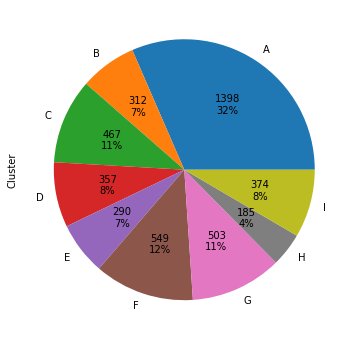

In [145]:
# plot clusters
plt.figure(figsize=(6, 6))
df.groupby('Cluster').size().plot(kind='pie', autopct=label_function, label='Cluster')

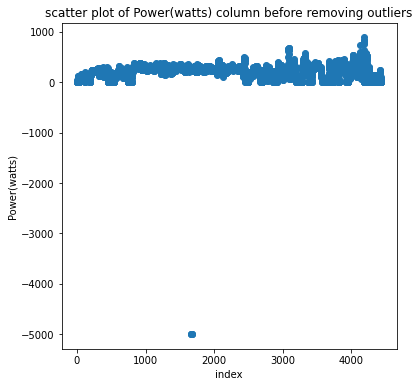

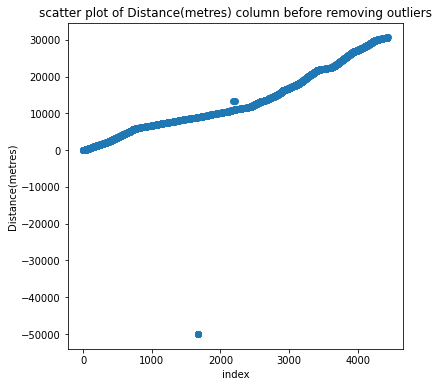

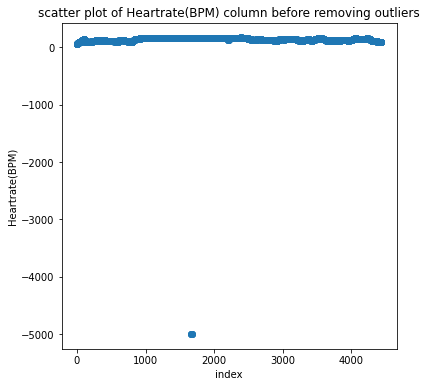

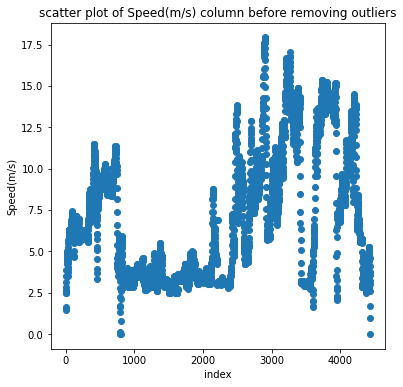

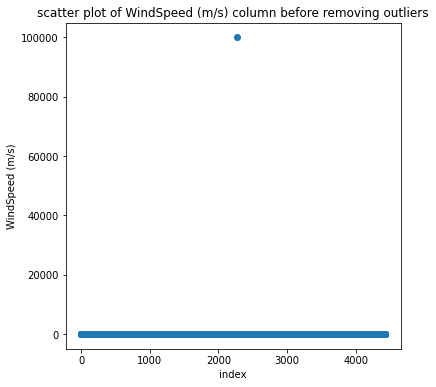

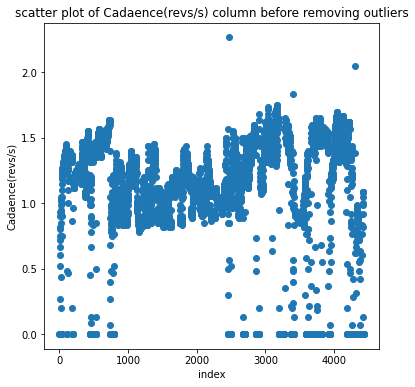

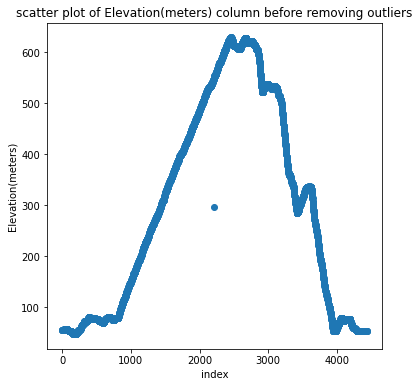

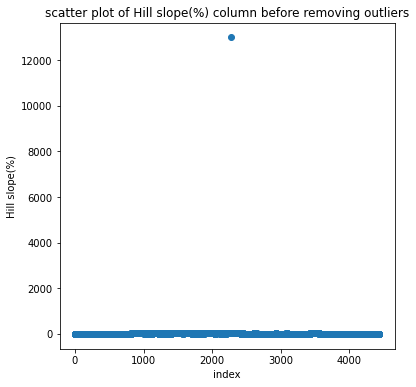

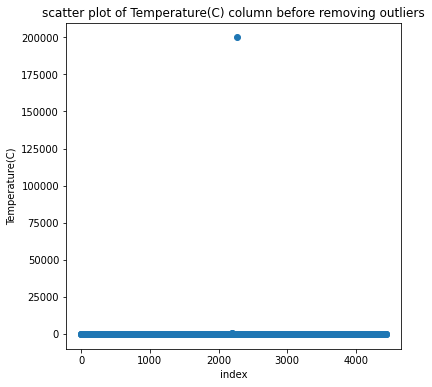

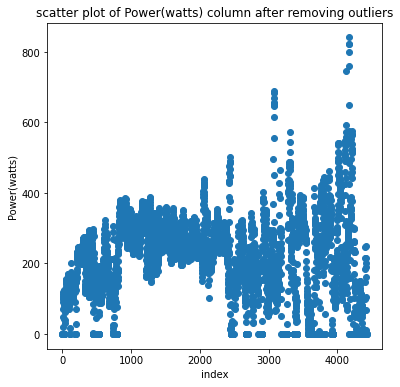

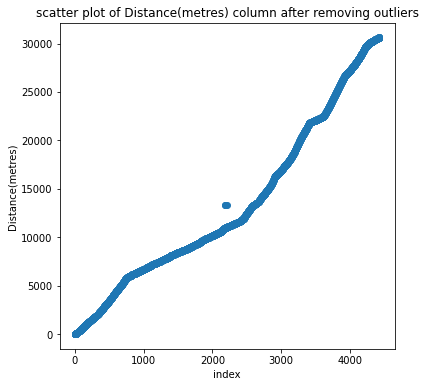

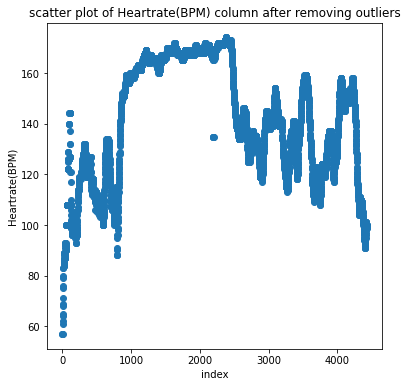

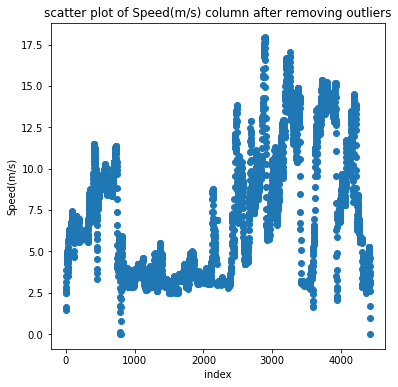

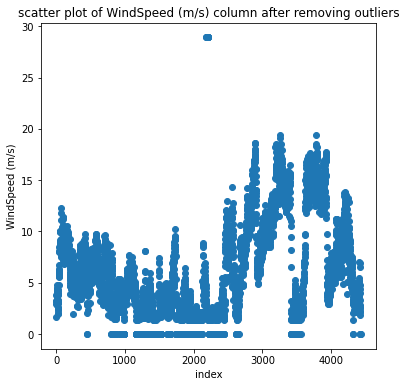

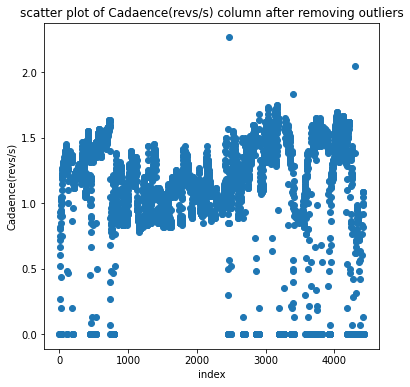

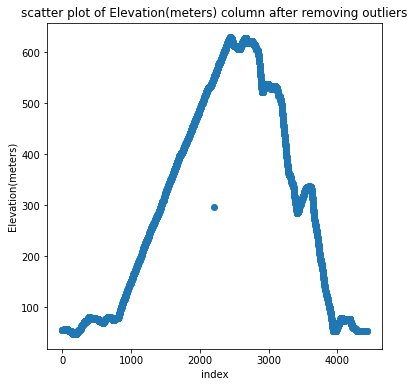

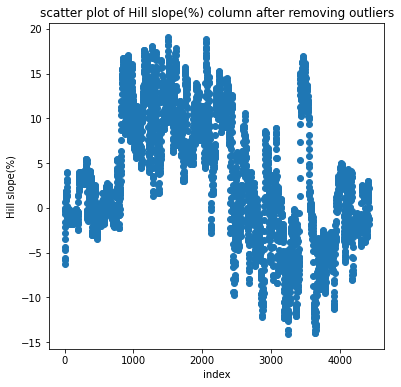

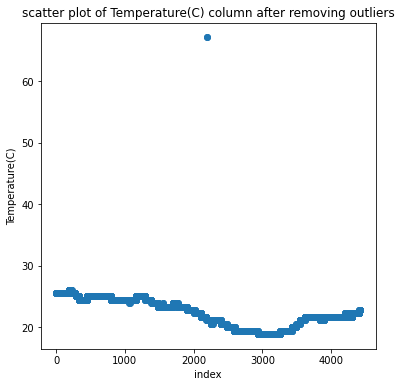

In [149]:
# since total number of null values is insignificant, we fill them by median of each column
df.fillna(df.mean(), inplace=True)

x_axis = [i for i in range(4435)]
# plot scatter plot of each column to find noisy data
for col in df:
  if col == 'Cluster':
    continue

  column = df[col]
  plt.figure(figsize=(6, 6))
  plt.title(f'scatter plot of {col} column before removing outliers')
  plt.scatter(x_axis, column)
  plt.xlabel('index')
  plt.ylabel(col)
  plt.show()

# remove outlier data using zscore
x_df = df.drop(columns=['Cluster'])
z_scores = st.zscore(x_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
clean_df = df[filtered_entries].copy()
for col in clean_df:
  if col == 'Cluster':
    continue
    
  column = clean_df[col]
  x_axis = [i for i in range(len(column))]
  plt.figure(figsize=(6, 6))
  plt.title(f'scatter plot of {col} column after removing outliers')
  plt.scatter(x_axis, column)
  plt.xlabel('index')
  plt.ylabel(col)
  plt.show()

In [147]:
clean_df.describe()

,Power(watts),Distance(metres),Heartrate(BPM),WindSpeed (m/s),Cadaence(revs/s),Elevation(meters),Temperature(C)
count,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000
mean,210.150463,13382.146790,141.623085,6.370459,1.057344,297.351059,22.372704
std,120.814477,8541.467383,23.405583,4.947845,0.454382,204.350136,2.354104
min,0.000000,0.000000,57.000000,0.000000,0.000000,48.158000,18.889000
25%,132.795000,7081.100000,123.000000,2.548100,0.900000,78.334000,20.556000
50%,229.870000,11056.000000,142.000000,5.409200,1.150000,289.560000,22.222000
75%,289.735000,20624.000000,166.000000,9.209000,1.383300,508.410000,24.444000
max,841.190000,30626.000000,174.000000,28.913162,2.266700,628.500000,67.067109


columns to be removed: {'Hill slope(%)', 'Speed(m/s)'}


,Power(watts),Distance(metres),Heartrate(BPM),WindSpeed (m/s),Cadaence(revs/s),Elevation(meters),Temperature(C),Cluster
0,0.0,0.000,57.0,1.6093,0.0,55.778,25.556,C
1,0.0,0.000,57.0,2.9505,0.0,55.778,25.556,C
2,0.0,0.000,57.0,3.1740,0.0,55.778,25.556,C
3,0.0,16.093,61.0,3.8445,0.0,55.778,25.556,C
4,0.0,16.093,62.0,3.2187,0.0,55.778,25.556,C


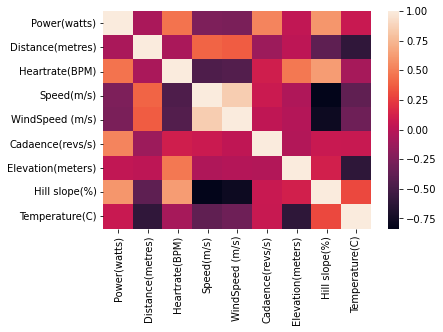

In [152]:
# Dimensionality Reduction using High Correlation Filter
corr_matrix = clean_df.corr()
sns.heatmap(corr_matrix)
corr_pairs = corr_matrix.unstack()
strong_pairs = corr_pairs[(abs(corr_pairs) >= 0.7) & (corr_pairs!=1.0)].drop_duplicates()
toBeRemoved = set()
for pair, value in strong_pairs.items():
  if abs(corr_matrix['WindSpeed (m/s)'][pair[0]]) > abs(corr_matrix['WindSpeed (m/s)'][pair[1]]) :
    toBeRemoved.add(pair[1])
  else:
    toBeRemoved.add(pair[0])

print('columns to be removed:', toBeRemoved)
clean_df.drop(list(toBeRemoved), axis=1, inplace=True)

clean_df.head()

In [153]:
x = clean_df.values[:, 0:7]
y = clean_df.values[:, 7]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(x_train)
normalized_x_train = scaler.transform(x_train)
normalized_x_test = scaler.transform(x_test)

In [154]:
# Gaussian mixture model as a probabilistic hierarical clustering
NUMBER_OF_CLUSTERS = 9

gm = GaussianMixture(n_components=NUMBER_OF_CLUSTERS, random_state=0)
gm.fit(normalized_x_train)
y_train_proba = gm.predict_proba(normalized_x_train)
y_test_proba = gm.predict_proba(normalized_x_test)

# calculate log loss or cross entroty error 
print('cross entropy loss of train data using gaussian mixture model:', log_loss(y_train, y_train_proba))
print('cross entropy loss of test data using gaussian mixture model:', log_loss(y_test, y_test_proba))

cross entropy loss of train data using gaussian mixture model: 21.94360553799446
cross entropy loss of test data using gaussian mixture model: 21.207676220995438


In [155]:
# kmeans clustering
kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0)
kmeans.fit(normalized_x_train)
y_train_predict = kmeans.predict(normalized_x_train)
y_test_predict = kmeans.predict(normalized_x_test)

# v_measure = (1 + beta) * homogeneity * completeness / (beta * homogeneity + completeness)
print('v_measure for quality of train data clustering using kmeans:', v_measure_score(y_train, y_train_predict))
print('v_measure for quality of test data clustering using kmeans:', v_measure_score(y_test, y_test_predict))

v_measure for quality of train data clustering using kmeans: 0.7129790939317665
v_measure for quality of test data clustering using kmeans: 0.69648153026056


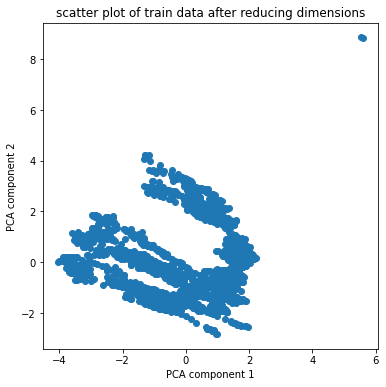

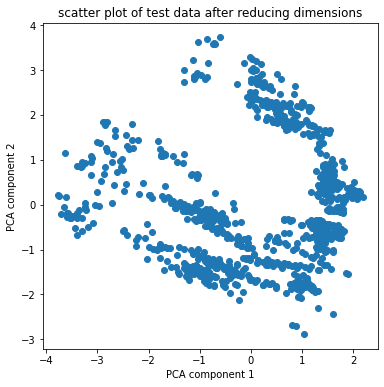

In [156]:
# Dimensionality reduction using PCA
pca = PCA(n_components=2)
pca.fit(normalized_x_train)
x_train_proj = pca.transform(normalized_x_train)
x_test_proj = pca.transform(normalized_x_test)
pca_train_1 = x_train_proj[:, 0]
pca_train_2 = x_train_proj[:, 1]
pca_test_1 = x_test_proj[:, 0]
pca_test_2 = x_test_proj[:, 1]

plt.figure(figsize=(6, 6))
plt.title(f'scatter plot of train data after reducing dimensions')
plt.scatter(pca_train_1, pca_train_2)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.show()

plt.figure(figsize=(6, 6))
plt.title(f'scatter plot of test data after reducing dimensions')
plt.scatter(pca_test_1, pca_test_2)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.show()

v_measure for quality of train data clustering using dbscan: 0.5840696073704928


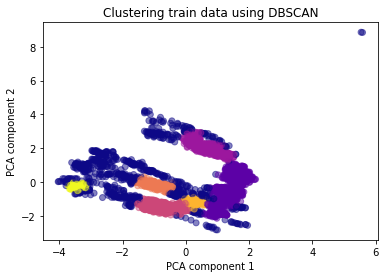

v_measure for quality of test data clustering using dbscan: 0.5048278491518139


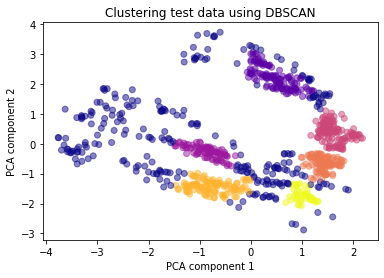

In [157]:
# DBSCAN clustering of train data
train_dbscan = DBSCAN(eps=0.25, min_samples=60)
y_train_predict_dbscan = train_dbscan.fit_predict(x_train_proj) 
print('v_measure for quality of train data clustering using dbscan:', v_measure_score(y_train, y_train_predict_dbscan))
plt.title('Clustering train data using DBSCAN')
plt.scatter(x_train_proj[:, 0], x_train_proj[:, 1], c=y_train_predict_dbscan, cmap='plasma', marker='o', alpha=0.5)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.show()

# DBSCAN clustering of test data
test_dbscan = DBSCAN(eps=0.25, min_samples=20)
y_test_predict_dbscan = test_dbscan.fit_predict(x_test_proj) 
print('v_measure for quality of test data clustering using dbscan:', v_measure_score(y_test, y_test_predict_dbscan))
plt.title('Clustering test data using DBSCAN')
plt.scatter(x_test_proj[:, 0], x_test_proj[:, 1], c=y_test_predict_dbscan, cmap='plasma', marker='o', alpha=0.5)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.show()